# **Tutorial: Running PACells on CLL data (binary phenotype task)**

This tutorial demonstrates the core PACells workflow using scATAC-seq from CLL samples. The bulk guidance data are CLL bulk ATAC-seq profiles including IGHV mutated and IGHV unmutated control samples. We use a binary phenotype where **IGHV mutated = 1** and **Control = 0**.

**In this tutorial, you will:**
- Load bulk ATAC-seq and scATAC-seq inputs.
- Prepare TF motifs.
- Run `PACells()` and obtain `PACells_label` for each cell.
- Visualize the identified phenotype-associated cells.

**Outputs:**
- A Seurat object containing `PACells_label` (`PACells` vs `Background`).
- A UMAP plot highlighting phenotype-associated cells.


## Step 1: Import libraries
We load PACells and the dependencies required for motif processing and visualization.

In [1]:
library(PACells)
library(JASPAR2022)
library(BSgenome.Hsapiens.UCSC.hg19)
library(ggplot2)
setwd("~CLL/")

载入需要的程辑包：Seurat

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

载入需要的程辑包：chromVAR

Warning message:
“从‘BSgenome’导出功能里找不到适用于‘releaseName’的相应方法”


载入需要的程辑包：SGL

载入需要的程辑包：chromVARmotifs

载入需要的程辑包：motifmatchr

载入需要的程辑包：Signac

载入需要的程辑包：SummarizedExperiment

载入需要的程辑包：MatrixGenerics

载入需要的程辑包：matrixStats


载入程辑包：‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQR

## Step 2: Load tutorial inputs

For convenience and reproducibility, we provide the processed inputs as `.rds` files. These files store the **count matrices**, **peak coordinates (GRanges)**, and **metadata tables** for both bulk and single-cell microglia ATAC-seq, so users can run the tutorial directly without repeating data conversion steps.

Set the working directory to the folder that contains the `.rds` files, then load them:


In [2]:
bulk_mtx <- readRDS("bulk_mtx.rds")
bulk_meta_mtx <- readRDS("bulk_meta_mtx.rds")
bulk_peak_GR <- readRDS("bulk_peak_GR.rds")

sc_mtx <- readRDS("sc_mtx.rds")
sc_meta_mtx <- readRDS("sc_meta_mtx.rds")
sc_peak_GR <- readRDS("sc_peak_GR.rds")

## Step 3: Create Seurat objects and define the bulk phenotype (binary)
We use `creatSeurat()` to wrap each dataset into a Seurat object with a Signac `ChromatinAssay`.

`genome` must match the coordinate system of the input peak `GRanges` (hg19 vs hg38). In this tutorial, peaks are in **hg19**, so we use `genome = "hg19"`.

`min.cells` filters peaks by detection frequency (non-zero counts in at least `min.cells` columns). We set `min.cells = 1` to keep the tutorial broadly applicable and avoid removing rare peaks. Users can increase it for large datasets to reduce sparsity and memory usage, but should avoid over-filtering when rare subpopulations are relevant.

The phenotype is defined on bulk microglia samples and is stored in `bulk_meta_mtx$phenotype`. We use a binary encoding with IGHV mutated = 1 and IGHV unmutated = 0.

Before running PACells, verify that the phenotype vector is aligned to bulk samples (columns of `bulk_dataset`) and has the expected 0/1 values.

In [3]:
sc_dataset <- creatSeurat(sc_mtx, sc_peak_GR, 
                           sc_meta_mtx, genome = 'hg19',min.cells = 1)

bulk_dataset <- creatSeurat(bulk_mtx, bulk_peak_GR, bulk_meta_mtx, 
                                              genome = 'hg19', min.cells = 1)

phenotype <- bulk_dataset@meta.data$igvh_mutation_status
phenotype[which(phenotype == "mutated")] = '1'
phenotype[which(phenotype == "unmutated")] = '0'
phenotype <- as.numeric(phenotype)

dim(bulk_dataset)
dim(sc_dataset)
length(phenotype)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from atac to atac_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from atac to atac_”


[1] 111971     84

[1] 446154   5610

[1] 84

## Step 4: Prepare TF motifs and run PACells (IGHV mutated, binary phenotype)

PACells uses TF motif definitions to construct motif activity matrices for both bulk and single-cell ATAC-seq data. In this tutorial, we load JASPAR2022 motifs for Homo sapiens. This step may take noticeable time when the number of peaks (and cells) is large, because motif matching and motif activity scoring are performed before PACells assigns phenotype-associated cells.

After motifs are prepared, we run `PACells()` to link the bulk phenotype (IGHV mutated vs control) to individual single cells and return a Seurat object with a new metadata column PACells_label (PACells vs Background). Below we summarize the key parameters used in this tutorial and how to adjust them in practice:

Choose the model family based on how the bulk phenotype is defined. For this tutorial we use `family = "binomial"` for a binary phenotype (IGHV mutated = 1, Control = 0). Use `"gaussian"` for continuous outcomes (e.g., a quantitative clinical trait). Use `"cox"` for survival outcomes, where phenotype should provide time/status information aligned to bulk samples.

`method` specifies how similarity between bulk samples and single cells is computed in the shared feature space. PACells provides three options: KL (default), Pearson, and Spearman. In this tutorial we use `method = "KL"` as a generally default for scATAC-seq, especially when signals are sparse and distributions differ across samples/cells. 
    Also, Pearson (linear correlation) and Spearman (rank-based correlation) can be used as alternative choices. In practice, we recommend starting with KL and then optionally testing Pearson/Spearman. 
    `level` controls which aspect of the activity profiles is emphasized. We recommend level = TRUE (default) as the standard setting, and it focuses more on overall activity-level profiles and is typically more suitable when scATAC-seq data are sparse/noisy or when signals are relatively weak between bulk and single cells.
As the optional complementary setting, the FALSE emphasizes relative activity patterns and may be more suitable when data quality is higher and the signal is stronger between bulk and single-cell profiles. 

`cutoff` limits the maximum fraction of cells that can be labeled as PACells. For example, the default 0.1 means that no more than 10% of all cells will be labeled as phenotype-associated. Smaller cutoffs enforce a more stringent and focused subset, which can be helpful when phenotype-associated cells are expected to be rare, but may be overly conservative if the associated population is larger. Larger cutoffs return a broader subset and may include more background cells. As a practical starting point, we recommend cutoff = 0.1 for most datasets.
`screenRatio` controls the candidate pre-screening proportion before the final labeling step. The default 0.8 keeps a relatively large candidate pool and is a conservative choice that reduces the risk of dropping weaker phenotype-associated signals. Increasing screenRatio retains more candidates (safer but slower), while decreasing it can speed up the run but may be more aggressive and potentially miss weak signals. The screenRatio = "auto" can be used to select a candidate ratio based on stability under repeated subsampling of bulk samples.

These parameters (`sc_refgenome`, `bulk_refgenome`) must match the genome build of your peak coordinates and the BSgenome package used for motif processing (hg38 vs hg19). In this tutorial we use hg19 consistently for both bulk and single-cell data. Inconsistent genome builds can cause motif matching failures or produce misleading motif activity results.

Batch correction (optional; `batch`, `Batch_variable`, `dim_Batch`). We do not enforce batch correction by default (batch = "none") to avoid over-correction when batch effects are weak. When batch effects are evident (e.g., cross-study integration or clear batch-driven separation in uncorrected embeddings), we recommend batch = "harmony". If batch is not "none", the metadata column specified by `Batch_variable` must exist in sc_dataset@meta.data. `dim_Batch` specifies which dimensions are used by the batch correction step.


In [4]:
Sys.time()
motifs <- getMotifs("Homo sapiens", "JASPAR") 
CLL_seurat <- PACells(sc_dataset, bulk_dataset, phenotype,motifs,
                      cutoff = 0.1, screenRatio = 0.8,
                      family = c("binomial", "gaussian", "cox")[1],
                      method = c("KL", "Pearson", "Spearman")[1],
                      sc_refgenome="hg19", bulk_refgenome="hg19")
Sys.time()

[1] "2026-01-28 01:02:34 CST"

TF Activity Matrix done 
Similarty Matrix Done 
Pre-screening Done 


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Label Summary (B/P):  5084 526

[1] "2026-01-28 01:13:48 CST"

## Step 5: Visualize PACells labels
We visualize the selected phenotype-associated cells using UMAP colored by `PACells_label`.

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


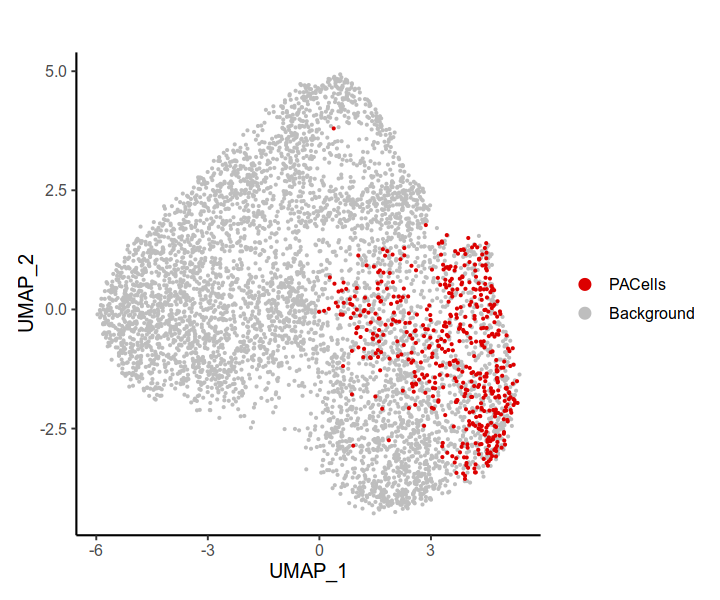

In [5]:
options(repr.plot.width=6, repr.plot.height=5)
DimPlot(object = CLL_seurat, group.by = 'PACells_label', pt.size= .5,order=c("PACells","Background"))+
scale_colour_discrete(breaks=c("PACells","Background"), type= c("gray","#DC0000" ))+
labs(title = "") + 
theme_classic(base_size = 12, base_family = "Arial") +
theme(
    axis.line = element_line(color = 'black',size = 0.6)
)

In [6]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.10

Matrix products: default
BLAS/LAPACK: /home/server/anaconda3/envs/PACAJ2BTest/lib/libopenblasp-r0.3.21.so

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
 [1] LC_CTYPE=zh_CN.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=zh_CN.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=zh_CN.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.4.3                     BSgenome.Hsapiens.UCSC.hg19_1.4.3
 [3] BSgenome_1.64.0                   rtracklayer_1.56.1               
 [5] Biostrings_2.66.0                 XV